In [1]:
import os
import numpy as np
import h5py
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from pytorch_lightning import LightningModule
from sklearn.model_selection import train_test_split

In [ ]:
# Path setup
model_path = "fine_tuned_model_v8-epoch=7336-train_loss=0.00666.ckpt"  
garstec_data = r'C:\Users\kiena\Documents\YEAR 4\PROJECT\Data\Garstec_AS09_chiara.hdf5'
save_dir = r'C:\Users\kiena\Python Project\Year4Project\dev\GarstecModel_V8' 
os.makedirs(save_dir, exist_ok=True)

In [4]:
class GarstecNet(LightningModule):
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        super().__init__()
        self.save_hyperparameters()
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=False)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)
        self.log('val_loss', loss, on_epoch=True, prog_bar=False)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
        return [optimizer], [scheduler]


In [5]:
def load_data():
    # 7 Inputs
    ages = []
    massini = []
    fehini = []
    alphamlt = []
    yini = []
    eta = []
    alphafe = []

    # 5 Outputs
    teff = []
    luminosity = []
    dnufit = []
    FeH = []
    numax = []

    # Open the hdf5 file
    with h5py.File(garstec_data, 'r') as hdf:
        grid = hdf['grid']
        tracks = grid['tracks']

        # Get track names and shuffle
        track_names = list(tracks.keys())
        random.seed(1)  # Use same seed as in training
        random.shuffle(track_names)

        # Choose a subset of tracks
        selected_tracks = track_names[:]

        for track_name in selected_tracks:
            track = tracks[track_name]
            # Inputs
            ages.append(track['age'][:])
            massini.append(track['massini'][:])
            fehini.append(track['FeHini'][:])
            alphamlt.append(track['alphaMLT'][:])
            yini.append(track['yini'][:])
            eta.append(track['eta'][:])
            alphafe.append(track['alphaFe'][:])

            # Outputs
            teff.append(track['Teff'][:])
            luminosity.append(track['LPhot'][:])
            dnufit.append(track['dnufit'][:])
            FeH.append(track['FeH'][:])
            numax.append(track['numax'][:])

    # Convert to numpy arrays and apply transformations
    epsilon = 1e-10
    
    # Transform inputs
    log10_vars_inputs = [ages, massini, alphamlt, eta, yini]
    log10_transformed_inputs = [np.log10(np.maximum(np.concatenate(var).reshape(-1, 1), epsilon)) for var in log10_vars_inputs]
    inputs = np.hstack(log10_transformed_inputs + [np.concatenate(fehini).reshape(-1, 1), 
                                                  np.concatenate(alphafe).reshape(-1, 1)])
    
    # Transform outputs
    log10_vars_outputs = [teff, luminosity, dnufit, numax]
    log10_transformed_outputs = [np.log10(np.maximum(np.concatenate(var).reshape(-1, 1), epsilon)) for var in log10_vars_outputs]
    outputs = np.hstack(log10_transformed_outputs + [np.concatenate(FeH).reshape(-1, 1)])
    
    # Create a list of output parameter names for plotting
    output_names = ['log T_eff', 'log L', 'log dnu', 'log numax', 'FeH']
    
    return inputs, outputs, output_names




In [14]:
# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
    
# Load data
inputs, outputs, output_names = load_data()
    
# Split data with same random state as in training
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.2, random_state=1)
    
# Scale data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
    
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
    
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)
    
# Load the trained model
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
    
# Load model with map_location to handle device differences
model = GarstecNet.load_from_checkpoint(
    model_path, 
    input_dim=input_dim, 
    output_dim=output_dim,
    map_location=device
)
model.eval()  # Set to evaluation mode
model.to(device)  # Ensure model is on the correct device
    
# Make predictions on test data
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
with torch.no_grad():
    y_pred = model(X_test_tensor).cpu().numpy()  # Move predictions back to CPU before converting to numpy
    
# Inverse transform predictions and actual values to get original scale
y_pred_original = scaler_y.inverse_transform(y_pred)
y_test_original = scaler_y.inverse_transform(y_test)
    
# Calculate residuals
residuals = y_pred_original - y_test_original
    

Using device: cuda


C:\Users\kiena\AppData\Local\Temp\ipykernel_10264\3625890911.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(residuals, patch_artist=True, labels=x_labels, showfliers=False)


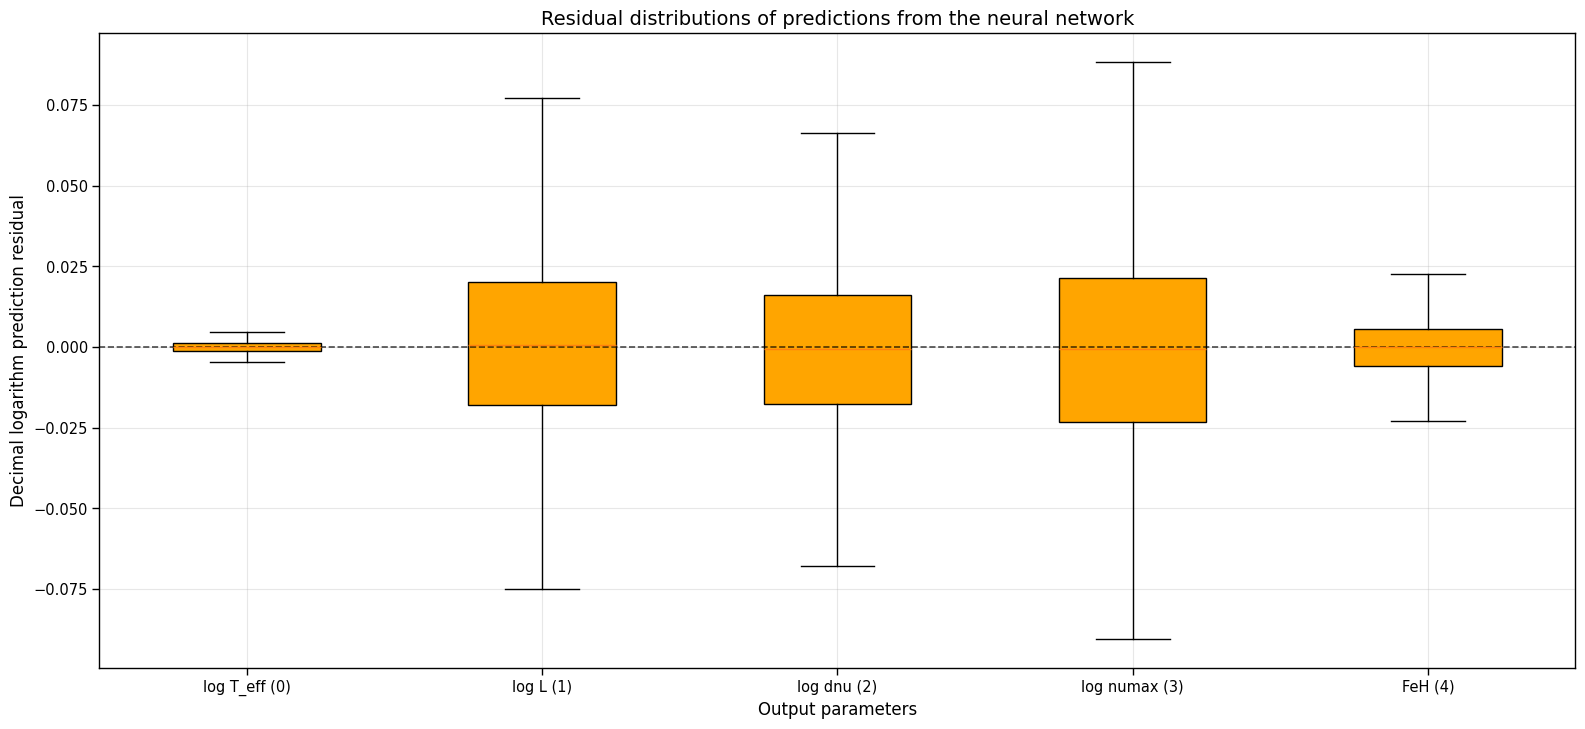

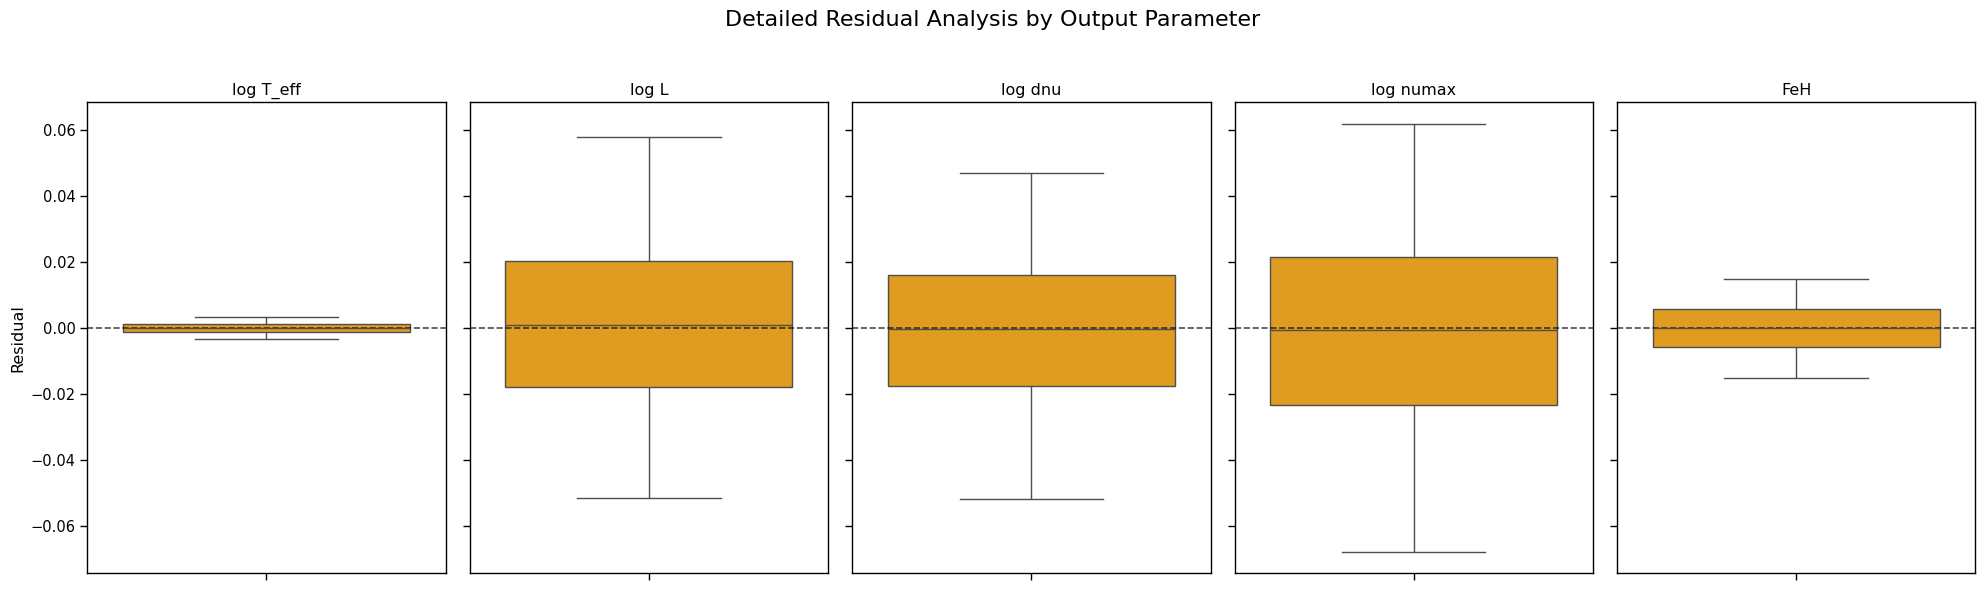


Residual Statistics:

log T_eff (Parameter 0):
  Mean: -0.000051
  Std Dev: 0.002222
  5th Percentile: -0.003477
  25th Percentile: -0.001226
  Median: -0.000014
  75th Percentile: 0.001145
  95th Percentile: 0.003234
  Min: -0.051033
  Max: 0.045194

log L (Parameter 1):
  Mean: 0.001541
  Std Dev: 0.034616
  5th Percentile: -0.051528
  25th Percentile: -0.017955
  Median: 0.000649
  75th Percentile: 0.020122
  95th Percentile: 0.057769
  Min: -0.299949
  Max: 0.330914

log dnu (Parameter 2):
  Mean: -0.001212
  Std Dev: 0.031012
  5th Percentile: -0.051767
  25th Percentile: -0.017589
  Median: -0.000479
  75th Percentile: 0.015965
  95th Percentile: 0.046686
  Min: -0.295532
  Max: 0.255252

log numax (Parameter 3):
  Mean: -0.001519
  Std Dev: 0.040805
  5th Percentile: -0.067937
  25th Percentile: -0.023377
  Median: -0.000595
  75th Percentile: 0.021329
  95th Percentile: 0.061799
  Min: -0.379697
  Max: 0.327233

FeH (Parameter 4):
  Mean: -0.000153
  Std Dev: 0.009645
  5th Pe

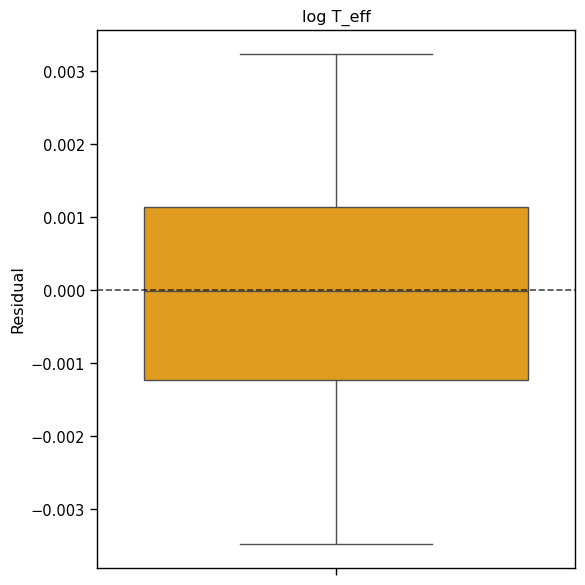

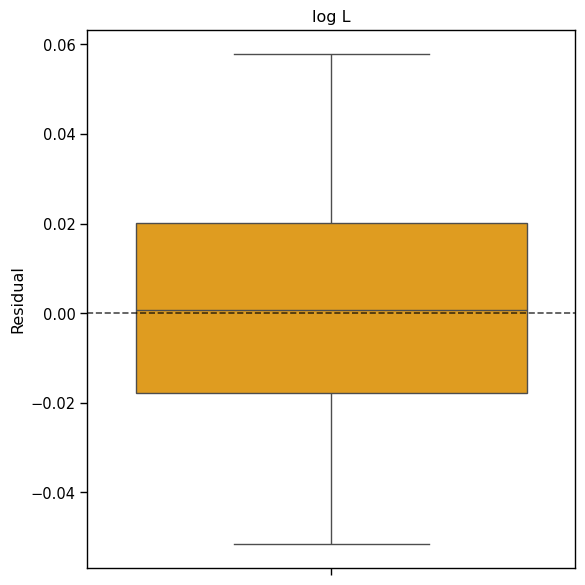

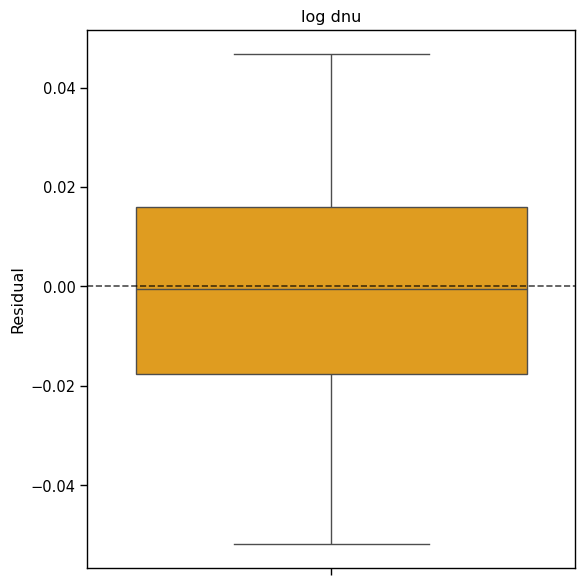

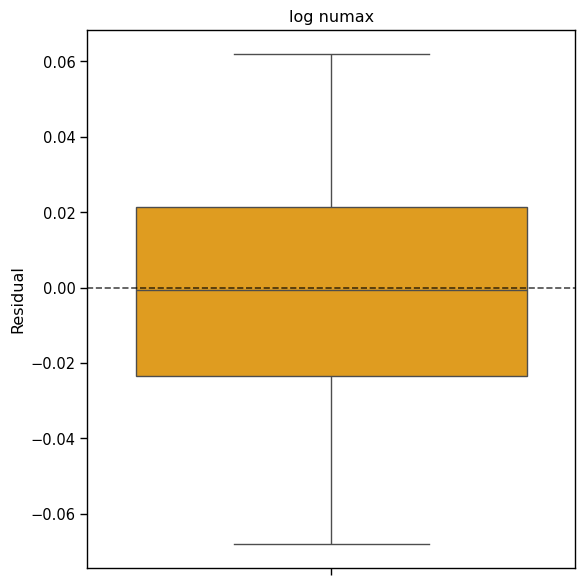

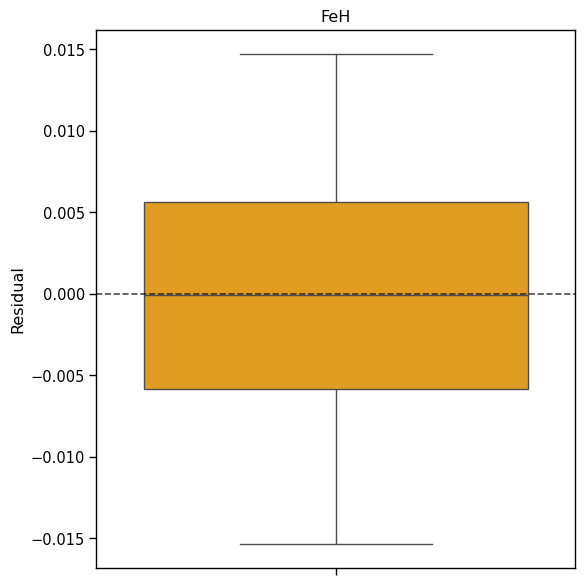

In [17]:
def main():
    
    plt.figure(figsize=(16, 8))
    
    # Prepare x-axis labels with indices
    x_labels = [f'{name} ({i})' for i, name in enumerate(output_names)]
    
    # Create boxplot
    boxplot = plt.boxplot(residuals, patch_artist=True, labels=x_labels, showfliers=False)
    
    # Customize boxplot colors
    for box in boxplot['boxes']:
        box.set(facecolor='orange')  # Orange color similar to the reference image
    
    # Add horizontal line at y=0
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)
    
    # Customize plot
    plt.title('Residual distributions of predictions from the neural network', fontsize=14)
    plt.xlabel('Output parameters', fontsize=12)
    plt.ylabel('Decimal logarithm prediction residual', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    
    # Adjust layout and save
    plt.tight_layout(rect=[0, 0.05, 1, 0.98])  # Adjust for the figtext
    plt.show()
    
    # Create separate boxplots for each output parameter with clear outlier visualization
    fig, axes = plt.subplots(nrows=1, ncols=len(output_names), figsize=(20, 6), sharey=True)
    
    for i, (ax, name) in enumerate(zip(axes, output_names)):
        sns.boxplot(y=residuals[:, i], ax=ax, color='orange', showfliers=False, 
                    whis=[5, 95])  # Set whiskers to 5th and 95th percentiles
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.7)
        ax.set_title(name)
        if i == 0:
            ax.set_ylabel('Residual')
        else:
            ax.set_ylabel('')
    
    fig.suptitle('Detailed Residual Analysis by Output Parameter', fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for the suptitle
    plt.show()
    
    # Calculate and print statistics for each output parameter
    print("\nResidual Statistics:")
    print("====================")
    
    for i, name in enumerate(output_names):
        param_residuals = residuals[:, i]
        stats = {
            'Mean': np.mean(param_residuals),
            'Std Dev': np.std(param_residuals),
            '5th Percentile': np.percentile(param_residuals, 5),
            '25th Percentile': np.percentile(param_residuals, 25),
            'Median': np.median(param_residuals),
            '75th Percentile': np.percentile(param_residuals, 75),
            '95th Percentile': np.percentile(param_residuals, 95),
            'Min': np.min(param_residuals),
            'Max': np.max(param_residuals)
        }
        
        print(f"\n{name} (Parameter {i}):")
        for stat_name, value in stats.items():
            print(f"  {stat_name}: {value:.6f}")

    for i, name in enumerate(output_names):
        plt.figure(figsize=(6, 6))  # Create a new figure for each parameter
        sns.boxplot(
            y=residuals[:, i],
            color='orange',
            showfliers=False,  # Do not show outlier markers
            whis=[5, 95]       # Whiskers set to the 5th and 95th percentiles
        )
        plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)  # Zero line
        plt.title(name)
        plt.ylabel('Residual')
        plt.tight_layout()
    
        plt.show()

if __name__ == "__main__":
    main()